In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay

In [2]:
EXAM_NAMES = ['Kuis 2', 'UTS']
EXAM_NUMBERS = {
    'Kuis 2': ['IA', 'IB', 'IC'],
    'UTS': ['IA', 'IB']
}
EXAMS = []
for exam_name in EXAM_NAMES:
    for exam_number in EXAM_NUMBERS[exam_name]:
        EXAMS.append((exam_name, exam_number))

LB = {
    'All': 0.6562801963,
    'Kuis 2 IA': 0.1447276516,
    'Kuis 2 IB': 0.3178719202,
    'Kuis 2 IC': 0.6346878475,
    'UTS IA': 0.5107134316,
    'UTS IB': 0.4047760493
}

X_AXIS = 'nilai autograder'
Y_AXIS = 'nilai manual'
EPS = 0.001

import os 
import sys

module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path) 
    
from grader.src.ged.classes.general_cost_function import RelabelMethod
from grader.src.grader import Grader, GraphPreprocessType

REAL_GRADE_FILENAME = 'Real Results.csv' 
AFILE_PREFIX = 'Grade_'

real_dataframe = pd.read_csv(REAL_GRADE_FILENAME)
dataframes = {}
for node_cost in range(1, 4):
    for edge_cost in range(1, 4):
        if node_cost == edge_cost and node_cost != 1:
            continue
        for relabel_method in RelabelMethod.__iter__():
            for graph_preprocess_type in GraphPreprocessType.__iter__():
                for pref in ['', 'APR_']:
                    filename = f'{pref}Grade_{relabel_method.name}_{graph_preprocess_type.name}_C{node_cost}{edge_cost}.csv'
                    if filename not in os.listdir('./'):
                        continue
                    dataframes[filename] = pd.read_csv(filename).rename(columns={'grade': 'nilai autograder'})
                    dataframes[filename] = pd.merge(dataframes[filename], real_dataframe, on=['nim', 'exam_name', 'number'])
                    
SENDJAJA = 'Grade Results.csv'
dataframes[SENDJAJA] = pd.read_csv(SENDJAJA).rename(columns={'grade': 'nilai autograder'})
dataframes[SENDJAJA] = pd.merge(dataframes[SENDJAJA], real_dataframe, on=['nim', 'exam_name', 'number'])


# relabel_method = RelabelMethod.BOOLEAN_COUNT
# graph_preprocess_type = GraphPreprocessType.UNCOLLAPSE
# filename = f'Test Coef_{relabel_method.name}_{graph_preprocess_type.name}.csv'
# if filename in os.listdir('./'):
#     dataframes[filename] = pd.read_csv(filename).rename(columns={'grade': 'nilai autograder'})
#     dataframes[filename] = pd.merge(dataframes[filename], real_dataframe, on=['nim', 'exam_name', 'number'])

In [3]:
# Correlation function
def correlation(df):
    return df.corr()

In [4]:
# MAE (Mean Absolute Error) function
def mae(df):
    return mean_absolute_error(df[X_AXIS], df[Y_AXIS])

In [5]:
# Linear Regression Plot function
def linear_regression_plot(name, df):
    m, b = np.polyfit(df[X_AXIS], df[Y_AXIS], 1)
    print(f'Info for plot={name}: m={m}, b={b}')
    fig, ax = plt.subplots(figsize=(8, 8), dpi=60)
    ax.scatter(df[X_AXIS], df[Y_AXIS])
    ax.set_title(f'Perbandingan Hasil Penilaian Menggunakan Sistem Autograder\n dan Hasil Penilaian Manual oleh Pendidik\n{name}')
    ax.set_xlabel('Hasil Penilaian Menggunakan Sistem Autograder')
    ax.set_ylabel('Hasil Penilaian Manual oleh Pendidik')
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])
    ax.set_aspect(1)
    ax.plot(df[Y_AXIS], m * df[Y_AXIS] + b)
    plt.show()

In [6]:
# Confusion Matrix Plot function
def confusion_matrix_plot(name, df):
    bins = [10 * x - EPS for x in range(11)] + [100 + EPS]
    labels = range(11)

    cat_X = pd.cut(df[X_AXIS], bins=bins, labels=labels)
    cat_Y = pd.cut(df[Y_AXIS], bins=bins, labels=labels)
    categorized_grade = pd.concat([cat_X, cat_Y], axis=1)
    
    cm = confusion_matrix(categorized_grade[X_AXIS], categorized_grade[Y_AXIS], labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(10, 8), dpi=60)
    ax.set_title(f'Confusion Matrix Perbandingan Hasil Penilaian Menggunakan Sistem Autograder\n dan Hasil Penilaian Manual oleh Pendidik\n{name}')
    disp.plot(ax=ax)
    disp.ax_.set(xlabel=X_AXIS, ylabel=Y_AXIS)
    plt.show()

In [7]:
# Histogram Difference Plot Function
def histogram_dif_plot(name, df):
    n, bins, patches = plt.hist(x=df, bins='auto', rwidth=0.75)
    plt.grid(axis='y', alpha=0.80)
    plt.title(f'Histogram Perbedaan Nilai Autograder dengan Nilai Manual\n{name}')
    plt.xlabel('Nilai Perbedaan = Nilai Autograder - Nilai Manual')
    plt.ylabel('Frekuensi')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    plt.show()

In [8]:
# Print Correlations
all_correls = {}
correls = []
for name, df in dataframes.items():
    corr = correlation(df)
    correls.append((corr[X_AXIS][Y_AXIS], name))
    all_correls[name] = {}
    all_correls[name]['All'] = corr[X_AXIS][Y_AXIS]
    
correls.sort(key=lambda x: -x[0])
for corr, name in correls:
    print(f'{name}: {corr}')

Grade_NONE_UNCOLLAPSE_C31.csv: 0.7417276675702948
Grade_NONE_UNCOLLAPSE_C21.csv: 0.7398848454797088
Grade_BOOLEAN_COUNT_UNCOLLAPSE_C31.csv: 0.7358180288782381
Grade_NONE_UNCOLLAPSE_C32.csv: 0.735005886305757
Grade_BOOLEAN_COUNT_UNCOLLAPSE_C21.csv: 0.7319393693510458
Grade_BOOLEAN_COUNT_UNCOLLAPSE_C32.csv: 0.7266168903194004
Grade_NONE_UNCOLLAPSE_C11.csv: 0.7237943416739918
Grade_BOOLEAN_COUNT_UNCOLLAPSE_C11.csv: 0.7236863160356296
Grade_BOOLEAN_COUNT_UNCOLLAPSE_C23.csv: 0.7177360552267056
Grade_NONE_UNCOLLAPSE_C23.csv: 0.713313743749654
Grade_BOOLEAN_COUNT_UNCOLLAPSE_C12.csv: 0.7106692792826556
Grade_NONE_UNCOLLAPSE_C12.csv: 0.7057423028488686
Grade_BOOLEAN_COUNT_UNCOLLAPSE_C13.csv: 0.7014884576315665
Grade_NONE_UNCOLLAPSE_C13.csv: 0.6965302976978474
APR_Grade_BOOLEAN_COUNT_UNCOLLAPSE_C31.csv: 0.689574556131414
Grade_NONE_COLLAPSE_C11.csv: 0.6882330939397963
APR_Grade_NONE_UNCOLLAPSE_C31.csv: 0.6867460218813072
APR_Grade_NONE_UNCOLLAPSE_C21.csv: 0.6866264205067446
APR_Grade_BOOLEAN_COU

In [9]:
exam_correls = {}
for exam in EXAMS:
    exam_correls[exam] = []
    for _, name in correls:
        df = dataframes[name]
        corr = correlation(df.loc[(df['exam_name'] == exam[0]) & (df['number'] == exam[1])])
        exam_correls[exam].append((corr[X_AXIS][Y_AXIS], name))
        all_correls[name][f'{exam[0]} {exam[1]}'] = corr[X_AXIS][Y_AXIS]
    exam_correls[exam].sort(reverse=True)
    
for exam in EXAMS:
    for corr, name in exam_correls[exam][:10]:
        print(f'{exam} {name}:\n {corr}', '\n-----\n')
    print('\n\n\n')
# for _, name in correls[90: 120]:
#     df = dataframes[name]
#     for exam in EXAMS:
#         corr = correlation(df.loc[(df['exam_name'] == exam[0]) & (df['number'] == exam[1])])
#         print(f'{exam} {name}:\n {corr[X_AXIS][Y_AXIS]}', '\n-----\n')

('Kuis 2', 'IA') APR_Grade_EXACT_PROPAGATE_BRANCHING_C13.csv:
 0.1548232144812056 
-----

('Kuis 2', 'IA') APR_Grade_NONE_PROPAGATE_BRANCHING_C13.csv:
 0.1547988322125838 
-----

('Kuis 2', 'IA') APR_Grade_NONE_PROPAGATE_BRANCHING_C12.csv:
 0.15460919671318943 
-----

('Kuis 2', 'IA') APR_Grade_NONE_PROPAGATE_BRANCHING_C23.csv:
 0.15434919566288355 
-----

('Kuis 2', 'IA') APR_Grade_EXACT_PROPAGATE_BRANCHING_C12.csv:
 0.15427742378484177 
-----

('Kuis 2', 'IA') APR_Grade_NONE_PROPAGATE_BRANCHING_C11.csv:
 0.15367149733235155 
-----

('Kuis 2', 'IA') APR_Grade_EXACT_PROPAGATE_BRANCHING_C23.csv:
 0.15336298641112295 
-----

('Kuis 2', 'IA') APR_Grade_NONE_PROPAGATE_BRANCHING_C32.csv:
 0.15241667311454626 
-----

('Kuis 2', 'IA') APR_Grade_NONE_PROPAGATE_BRANCHING_C21.csv:
 0.15104424024806187 
-----

('Kuis 2', 'IA') APR_Grade_EXACT_PROPAGATE_BRANCHING_C11.csv:
 0.15095940737084554 
-----





('Kuis 2', 'IB') Grade_BOOLEAN_COUNT_UNCOLLAPSE_C23.csv:
 0.6031040549564886 
-----

('Kuis 2'

In [10]:
count_top = {}
for exam in EXAMS:
    for corr, name in exam_correls[exam]:
        if corr >= LB[f'{exam[0]} {exam[1]}'] * 0.8:
            if name not in count_top:
                count_top[name] = 0
            count_top[name] += 1
    
top_name = [x for x in count_top.items()]
top_name.sort(reverse=True, key=lambda x: (x[1], all_correls[x[0]]['All']))
vis = {}
for name, count in top_name:
    if count not in vis:
        vis[count] = 0
    if vis[count] >= 3:
        continue
    print(f'{name}: {count}')
    for exam, corr in all_correls[name].items():
        print(f'{exam}: {corr}')
    print()
    vis[count] += 1

Grade Results.csv: 5
All: 0.6562801963372779
Kuis 2 IA: 0.14472765155427839
Kuis 2 IB: 0.31787192021786037
Kuis 2 IC: 0.634687847477691
UTS IA: 0.5107134315754333
UTS IB: 0.40477604933116773

Grade_DAMERAU_LD_COLLAPSE_C31.csv: 4
All: 0.6816624651196788
Kuis 2 IA: 0.1196759674646612
Kuis 2 IB: 0.4382713529812896
Kuis 2 IC: 0.5887526597579713
UTS IA: 0.4946404566976894
UTS IB: -0.012149021502739424

Grade_DAMERAU_LD_COLLAPSE_C21.csv: 4
All: 0.673465510741737
Kuis 2 IA: 0.11731449089542567
Kuis 2 IB: 0.4365113451551094
Kuis 2 IC: 0.5408904580638554
UTS IA: 0.4990247789261197
UTS IB: -0.037449451834289466

Grade_BOOLEAN_COUNT_COLLAPSE_C21.csv: 4
All: 0.6728634077133595
Kuis 2 IA: 0.12072566355372279
Kuis 2 IB: 0.4022443036981158
Kuis 2 IC: 0.6298956271132445
UTS IA: 0.4857843602801148
UTS IB: -0.03913408004069107

Grade_NONE_UNCOLLAPSE_C21.csv: 3
All: 0.7398848454797088
Kuis 2 IA: -0.08792601958900419
Kuis 2 IB: 0.4646671940788259
Kuis 2 IC: 0.6704106500854555
UTS IA: 0.41417292868071004
U

In [11]:
# Print MAE
# for name, df in dataframes.items():
#     print(f'MAE (Mean Absolute Error) of dataframe {name} exam: {mae(df)}')
    
maes = []
for name, df in dataframes.items():
    maes.append((mae(df), name))
maes.sort()
for mae, name in maes:
    print(f'{name}: {mae}')

Grade_BOOLEAN_COUNT_UNCOLLAPSE_C21.csv: 10.408175342205327
Grade_BOOLEAN_COUNT_UNCOLLAPSE_C32.csv: 10.578886832183619
Grade_BOOLEAN_COUNT_UNCOLLAPSE_C31.csv: 10.717193279771946
Grade_NONE_UNCOLLAPSE_C32.csv: 11.10776456633298
Grade_NONE_COLLAPSE_C12.csv: 11.161981313013374
Grade_COUNTER_COLLAPSE_C21.csv: 11.331034813376897
Grade_NONE_UNCOLLAPSE_C21.csv: 11.364814680278853
Grade_DAMERAU_LD_COLLAPSE_C21.csv: 11.482847374743498
Grade_NONE_COLLAPSE_C13.csv: 11.520809110743539
Grade_COUNTER_COLLAPSE_C32.csv: 11.588733190512434
Grade_DAMERAU_LD_COLLAPSE_C31.csv: 11.5914567515265
Grade_BOOLEAN_COUNT_COLLAPSE_C32.csv: 11.643974493155584
Grade_NONE_COLLAPSE_C23.csv: 11.658801415824481
Grade_DAMERAU_LD_COLLAPSE_C32.csv: 11.6632873715194
Grade_DAMERAU_LD_COLLAPSE_C11.csv: 11.67355886680028
Grade_COUNTER_COLLAPSE_C31.csv: 11.713382236103392
Grade_BOOLEAN_COUNT_COLLAPSE_C21.csv: 11.725058627137031
APR_Grade_DAMERAU_LD_COLLAPSE_C32.csv: 11.73338139417703
APR_Grade_COUNTER_COLLAPSE_C32.csv: 11.755807

Linear Regression Plot of Grade Results.csv exam:
Info for plot=Grade Results.csv: m=0.6494050079710322, b=19.19245395383932


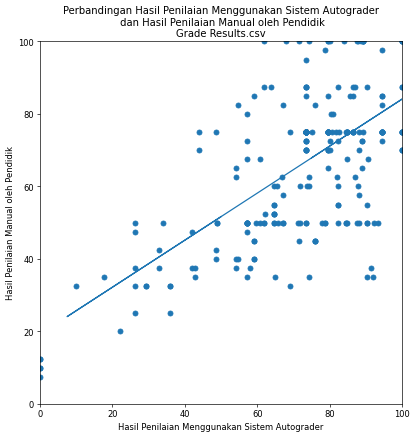

Linear Regression Plot of Grade_NONE_UNCOLLAPSE_C31.csv exam:
Info for plot=Grade_NONE_UNCOLLAPSE_C31.csv: m=0.817998122566247, b=6.690146414620903


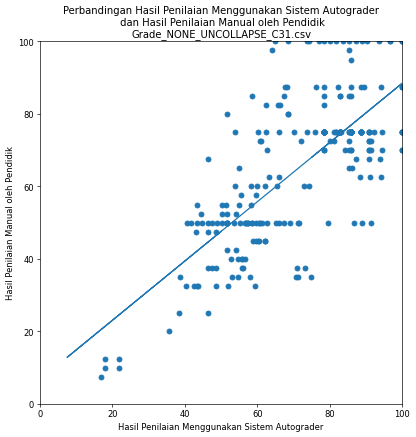

Linear Regression Plot of Grade_NONE_UNCOLLAPSE_C21.csv exam:
Info for plot=Grade_NONE_UNCOLLAPSE_C21.csv: m=0.7521148015557135, b=14.19529434670955


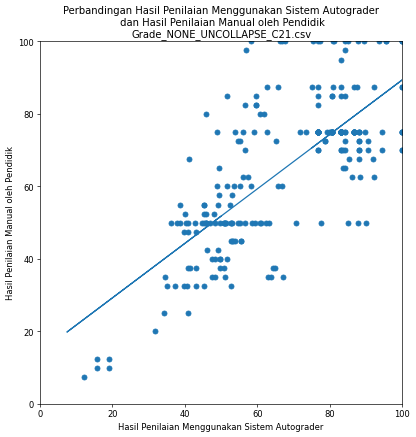

Linear Regression Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C31.csv exam:
Info for plot=Grade_BOOLEAN_COUNT_UNCOLLAPSE_C31.csv: m=0.8627414976230011, b=6.442975860159034


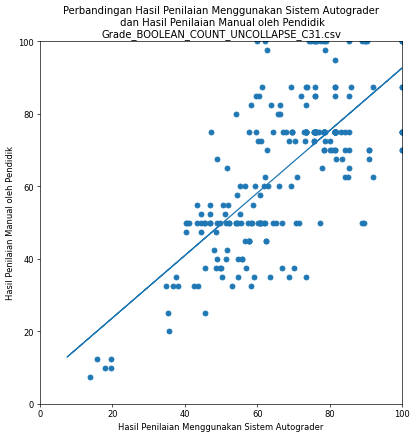

Linear Regression Plot of Grade_NONE_UNCOLLAPSE_C32.csv exam:
Info for plot=Grade_NONE_UNCOLLAPSE_C32.csv: m=0.7023706726910965, b=19.595557673633444


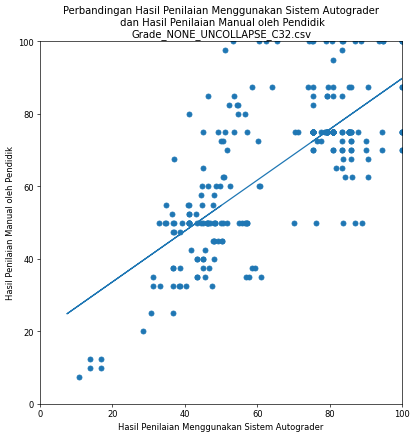

Linear Regression Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C21.csv exam:
Info for plot=Grade_BOOLEAN_COUNT_UNCOLLAPSE_C21.csv: m=0.7997091746715691, b=13.669483336722955


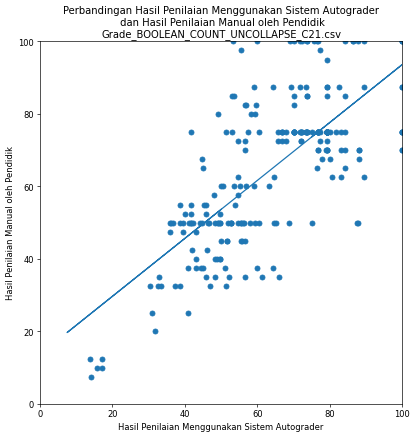

Linear Regression Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C32.csv exam:
Info for plot=Grade_BOOLEAN_COUNT_UNCOLLAPSE_C32.csv: m=0.7461649632536433, b=19.05397075489182


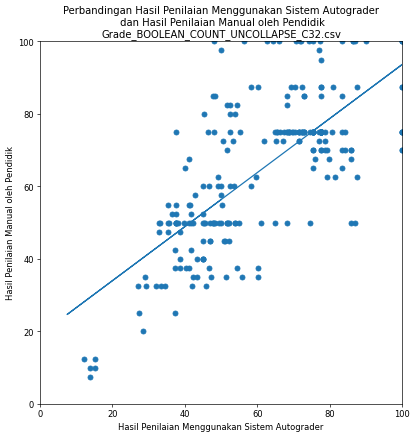

Linear Regression Plot of Grade_NONE_UNCOLLAPSE_C11.csv exam:
Info for plot=Grade_NONE_UNCOLLAPSE_C11.csv: m=0.6347270501176049, b=26.644043010739313


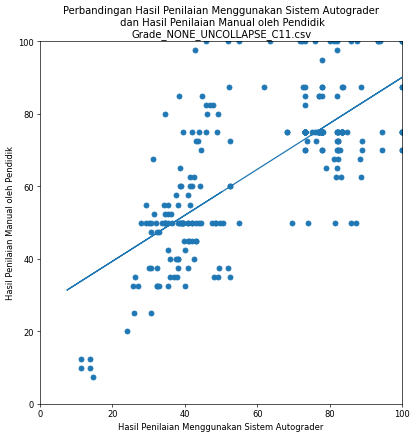

Linear Regression Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C11.csv exam:
Info for plot=Grade_BOOLEAN_COUNT_UNCOLLAPSE_C11.csv: m=0.6758535407572583, b=25.9468026620686


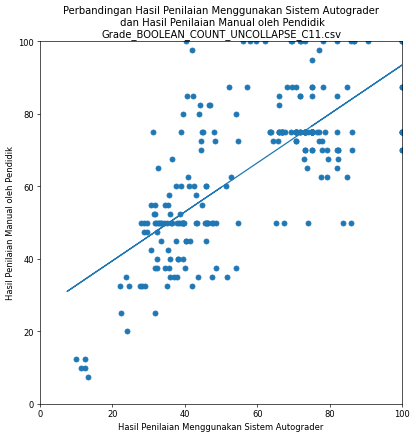

Linear Regression Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C23.csv exam:
Info for plot=Grade_BOOLEAN_COUNT_UNCOLLAPSE_C23.csv: m=0.6109664675038544, b=31.885150372559792


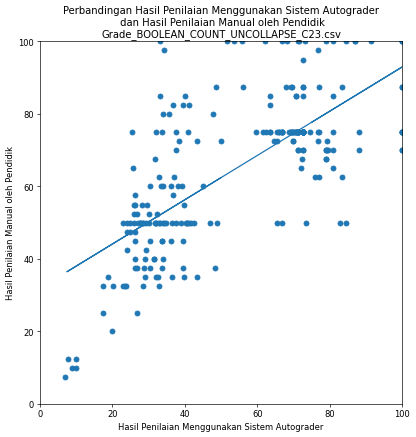

Linear Regression Plot of Grade_NONE_UNCOLLAPSE_C23.csv exam:
Info for plot=Grade_NONE_UNCOLLAPSE_C23.csv: m=0.5767083540651347, b=32.50105039205117


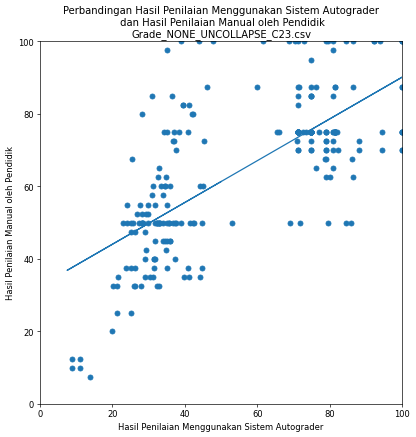

In [12]:
for _, name in [(all_correls[SENDJAJA]['All'], SENDJAJA)] + correls[:10]:
    df = dataframes[name]
    print(f'Linear Regression Plot of {name} exam:')
    linear_regression_plot(name, df)

Confusion Matrix Plot of Grade Results.csv exam:


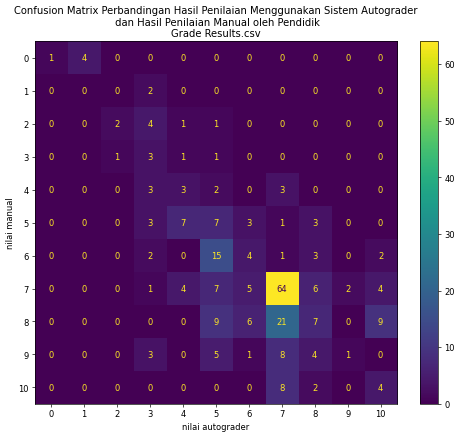

Confusion Matrix Plot of Grade_NONE_UNCOLLAPSE_C31.csv exam:


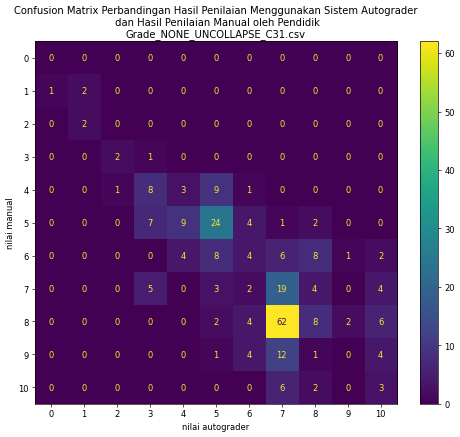

Confusion Matrix Plot of Grade_NONE_UNCOLLAPSE_C21.csv exam:


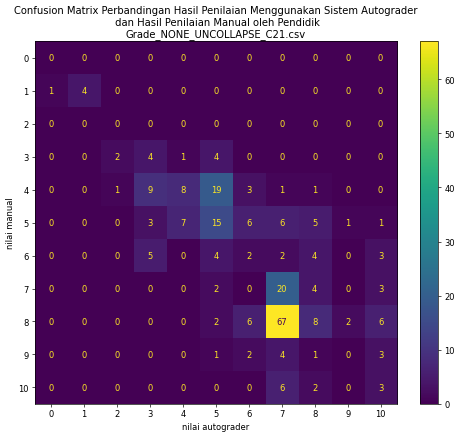

Confusion Matrix Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C31.csv exam:


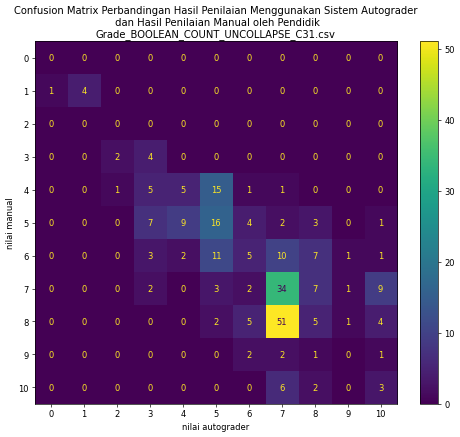

Confusion Matrix Plot of Grade_NONE_UNCOLLAPSE_C32.csv exam:


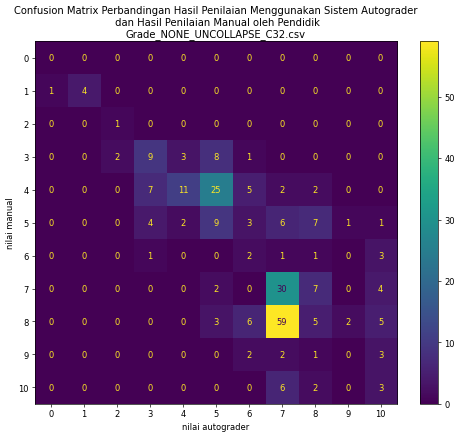

Confusion Matrix Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C21.csv exam:


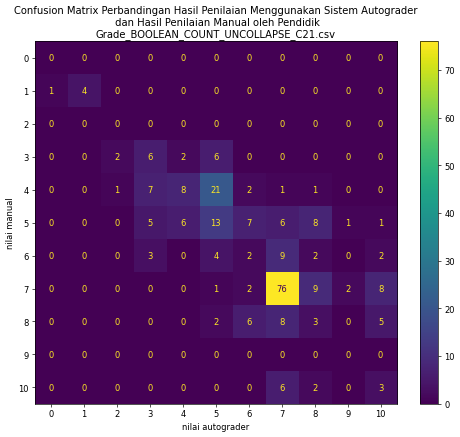

Confusion Matrix Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C32.csv exam:


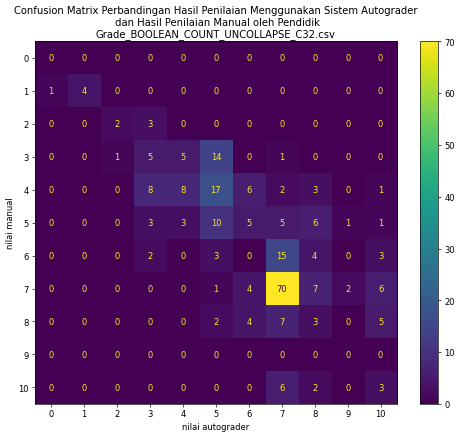

Confusion Matrix Plot of Grade_NONE_UNCOLLAPSE_C11.csv exam:


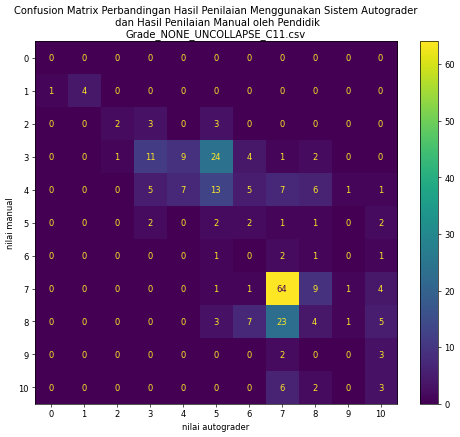

Confusion Matrix Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C11.csv exam:


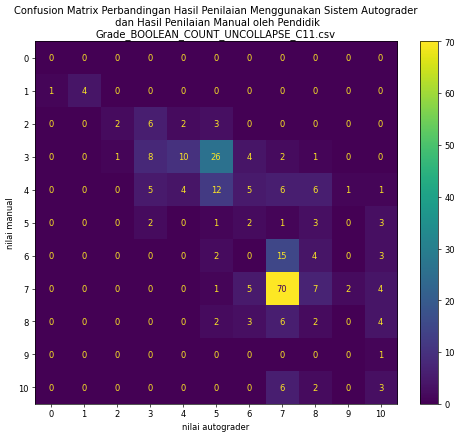

Confusion Matrix Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C23.csv exam:


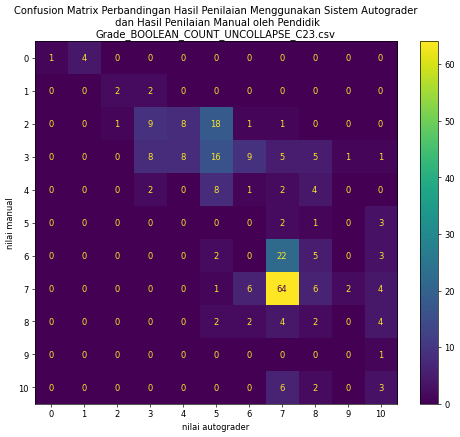

Confusion Matrix Plot of Grade_NONE_UNCOLLAPSE_C23.csv exam:


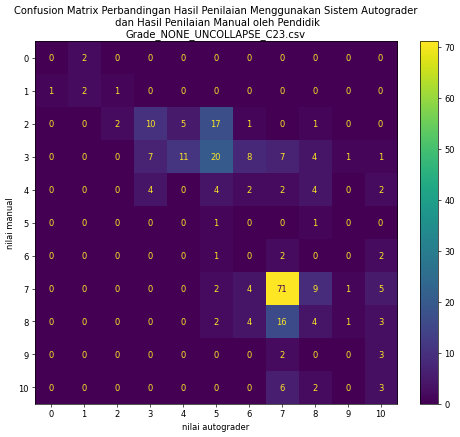

In [13]:
for _, name in [(all_correls[SENDJAJA]['All'], SENDJAJA)] + correls[:10]:
    df = dataframes[name]
    print(f'Confusion Matrix Plot of {name} exam:')
    confusion_matrix_plot(name, df)

Histogram Difference Plot of Grade Results.csv exam:
Data correlation: 0.6562801963372779, Average difference: 5.890472719041822


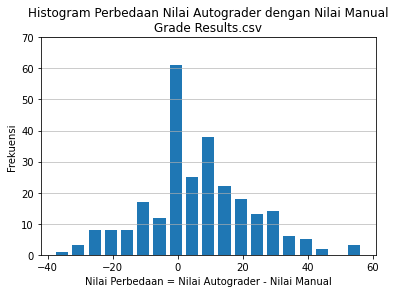

Histogram Difference Plot of Grade_NONE_UNCOLLAPSE_C31.csv exam:
Data correlation: 0.7417276675702948, Average difference: 6.428984559710746


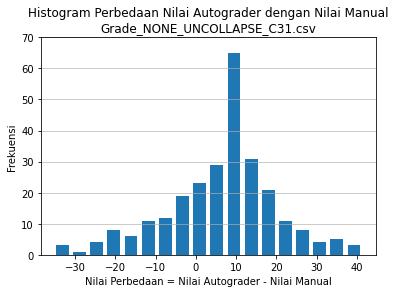

Histogram Difference Plot of Grade_NONE_UNCOLLAPSE_C21.csv exam:
Data correlation: 0.7398848454797088, Average difference: 2.7644901948926033


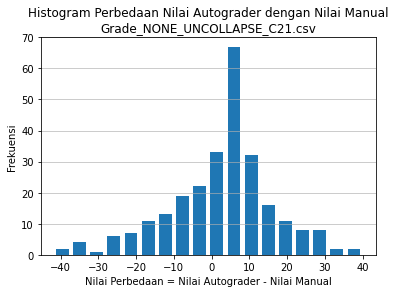

Histogram Difference Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C31.csv exam:
Data correlation: 0.7358180288782381, Average difference: 2.9771521999118757


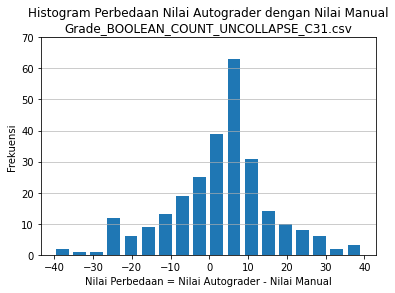

Histogram Difference Plot of Grade_NONE_UNCOLLAPSE_C32.csv exam:
Data correlation: 0.735005886305757, Average difference: -0.07855921739801135


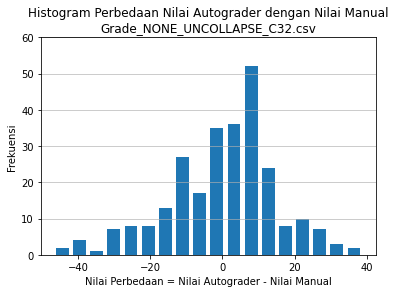

Histogram Difference Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C21.csv exam:
Data correlation: 0.7319393693510458, Average difference: -0.6498710540530104


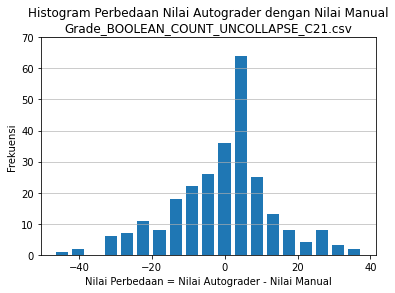

Histogram Difference Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C32.csv exam:
Data correlation: 0.7266168903194004, Average difference: -3.2014840731208647


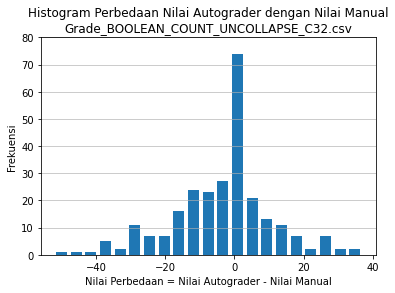

Histogram Difference Plot of Grade_NONE_UNCOLLAPSE_C11.csv exam:
Data correlation: 0.7237943416739918, Average difference: -4.194919062885288


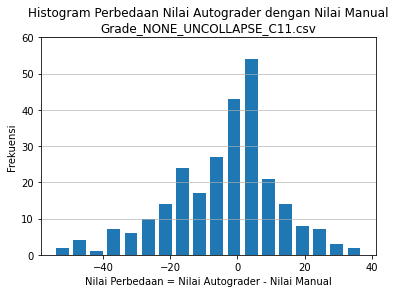

Histogram Difference Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C11.csv exam:
Data correlation: 0.7236863160356296, Average difference: -6.903097027216536


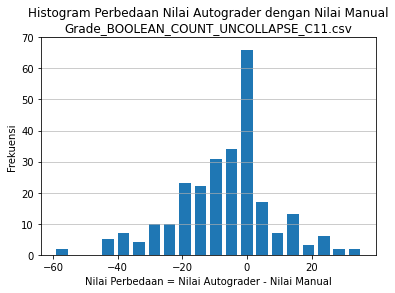

Histogram Difference Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C23.csv exam:
Data correlation: 0.7177360552267056, Average difference: -10.383176575020205


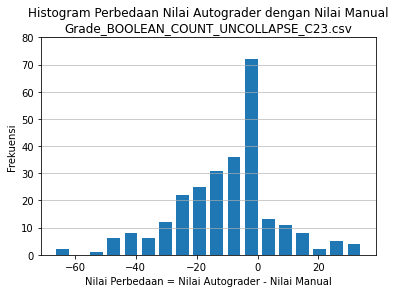

Histogram Difference Plot of Grade_NONE_UNCOLLAPSE_C23.csv exam:
Data correlation: 0.713313743749654, Average difference: -8.167925370807401


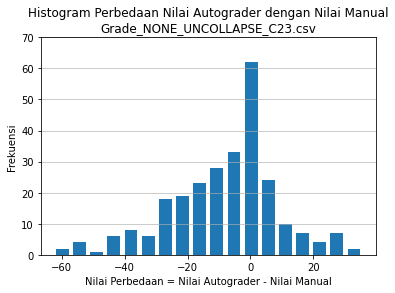

In [14]:
# Show Histogram Difference Plot
for corr, name in [(all_correls[SENDJAJA]['All'], SENDJAJA)] + correls[:10]:
    df = dataframes[name]
    print(f'Histogram Difference Plot of {name} exam:')
    print(f'Data correlation: {corr}, Average difference: {np.average(df[X_AXIS] - df[Y_AXIS])}')
    histogram_dif_plot(name, df[X_AXIS] - df[Y_AXIS])